# Импорт библиотек

In [750]:
# инициализация библиотек
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC

# библиотека подсчета статистики распредления для вывода графика
import statsmodels.api as sm

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

import warnings

warnings.simplefilter('ignore')

# доп. настройки пандас чтобы показывал всё без пропусков
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)

## Код функций и классов

In [751]:
# класс логарифмирования признака
class LogColumn():
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'

    def df_col_log(self):
        return self.df[self.col].apply(lambda x: np.log(x + 1))


# класс визуализации для числового признака и нахождения выбросов до логарифмирования и после.
class InspectColumn():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogColumn(df, col).col_log
        self.df_log = LogColumn(df, col).df_col_log()
        self.show_plots()

    # выбросы и графики до логарифмирования и после
    def show_plots(self, size=5, log=False):
        # вывод количества выбросов в исходном признаке
        self.outliers(self.df, self.col, '')
        # вывод количества выбросов после логарифмирования признака
        self.outliers(self.df_log, self.col_log, 'после log')

        column = self.col

        f = plt.figure()
        f.clear()
        plt.close(f)

        # вывод графиков по исходному признаку
        size = 5  # базовый размер выводимых графиков
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * size, size))

        # гистограмма
        ax1.hist(self.df.dropna(),
                 bins=20,
                 histtype='bar',
                 align='mid',
                 rwidth=0.8,
                 color='green')
        ax1.set_title("общий вид")

        # выбросы
        ax2.boxplot(self.df.dropna(), vert=False)
        ax2.set_title("выбросы boxplot")

        # распределение
        ax3.set_title("распределение")
        fig = sm.qqplot(self.df.dropna(), fit=True, line='45',
                        ax=ax3)  # сравнение с нормальным распределением
        fig.suptitle('histogram, boxplot, QQ-plot for {0} '.format(self.col))

        plt.show

        # вывод графиков по логарифмированному признаку
        fig1, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(3 * size, size))

        # гистограмма
        ax4.hist(self.df_log.dropna(),
                 bins=20,
                 histtype='bar',
                 align='mid',
                 rwidth=0.8,
                 color='green')
        ax4.set_title("общий вид log")

        # выбросы
        ax5.boxplot(self.df_log.dropna(), vert=False)
        ax5.set_title("выбросы boxplot log")

        # распределение
        ax6.set_title("распределение log")
        fig = sm.qqplot(self.df_log.dropna(), fit=True, line='45', ax=ax6)
        fig.suptitle('histogram, boxplot, QQ-plot for  {0} '.format(
            self.col_log))

        plt.show

    # границы выбросов
    def boundaries(self, data, column):
        q1 = data.quantile(q=0.25)
        q3 = data.quantile(q=0.75)
        IQR = q3 - q1
        return q1 - 1.5 * IQR, q3 + 1.5 * IQR

    # общее количество выбросов
    def outliers(self, data, column, comment=''):
        # получаем границы выбросов
        low_b, hihg_b = self.boundaries(data, column)

        # получаем количество выбросво по нижней и верхней границам
        cnt_low = len(data[data < low_b])
        cnt_hihg = len(data[data > hihg_b])

        # получаем общее количество выбросов
        cnt_all = cnt_low + cnt_hihg

        # записываем количество выбросов в датафрейм для вывода
        bord = {'low': [cnt_low], 'high': [cnt_hihg], 'all': [cnt_all]}
        df_bord = pd.DataFrame(bord)
        print('Количество выбросов ' + comment, end='')
        display(df_bord.head())


# функция добавляет новый логарифмированный признак в датасет,
# заменяет его на исходный в списке признаков новое имя колонки
def UseLogColumn(data, column, modify_list):

    new_column_name = column + '_log'

    # создаем новую колонку (признак) и записываем логарифм значения исходной колонки
    data[new_column_name] = data[column].apply(lambda x: np.log(x + 1))

    # исключаем исходный признак из колонок обработки информации
    modify_list.remove(column)

    # добавляем логарифмированный признок с меньшим количесиво выбросов
    modify_list.append(new_column_name)


# функция get_corr_value - выводит значения корреляций в удобной форме
#
# Параметры
#    corr_tab - pandas.core.frame.DataFrame - полученная в результате corr()
def get_corr_value(corr_tab):
    dic_corr = {}
    pozitve_corr = []
    pozitive_non_corr = []
    negative_corr = []
    negative_non_corr = []

    for r in range(len(corr_tab.columns)):
        for c in range(len(corr_tab.iloc[r].index)):
            value = corr_tab.iloc[r][corr_tab.iloc[r].index[c]]
            name_row = corr_tab.iloc[r].index[r]
            name_column = corr_tab.iloc[r].index[c]
            if value == 1.0:
                continue
            if value not in dic_corr:
                dic_corr[value] = {}
                dic_corr[value]['row'] = name_row
                dic_corr[value]['column'] = name_column
                if value >= 0.1:
                    pozitve_corr.append(value)
                elif value > 0 and value < 0.1:
                    pozitive_non_corr.append(value)
                elif value <= -0.1:
                    negative_corr.append(value)
                elif value < 0 and value > -0.1:
                    negative_non_corr.append(value)

    pozitve_corr.sort(reverse=True)
    pozitive_non_corr.sort(reverse=True)
    negative_corr.sort(reverse=False)
    negative_non_corr.sort(reverse=False)

    print('ПОЛОЖИТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:')
    print('')
    for i in pozitve_corr:
        print(i, ':', dic_corr[i]['row'], '-', dic_corr[i]['column'])

    print('')
    print('СЛАБУЮ ПОЛОЖИТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:')
    print('')
    for i in pozitive_non_corr:
        print(i, ':', dic_corr[i]['row'], '-', dic_corr[i]['column'])

    print('')
    print('ОТРИЦАТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:')
    print('')
    for i in negative_corr:
        print(i, ':', dic_corr[i]['row'], '-', dic_corr[i]['column'])

    print('')
    print('СЛАБУЮ ОТРИЦАТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:')
    print('')
    for i in negative_non_corr:
        print(i, ':', dic_corr[i]['row'], '-', dic_corr[i]['column'])


# Таблица метрик для сравнения результатов каждой модели
metrics = [
    'Accuracy', 'Precision', 'Recall', 'F1', 'Roc_Auc', 'M_Conf_TP',
    'M_Conf_FP', 'M_Conf_TN', 'M_Conf_FN'
]
summary = pd.DataFrame(index=metrics)

# заполнение метрик по модели
def summary_metrics(summary, new_col, y_valid, y_pred, y_pred_probs):
    Accuracy = accuracy_score(y_valid, y_pred)
    Precision = precision_score(y_valid, y_pred)
    Recall = recall_score(y_valid, y_pred)
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)
    F1 = f1_score(y_valid, y_pred)
    Roc_Auc = roc_auc_score(y_valid, y_pred_probs)
    M_Conf_TN, M_Conf_FP, M_Conf_FN, M_Conf_TP = confusion_matrix(
        y_valid, y_pred).ravel()
    values = [
        Accuracy, Precision, Recall, F1, Roc_Auc, M_Conf_TP, M_Conf_FP,
        M_Conf_TN, M_Conf_FN
    ]
    summary[new_col] = values
    return summary


# красивый вывод confusion_matrix
def confusion_matrix_plot(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cf_matrix = np.array([[tp, fp], [fn, tn]])
    group_names = ['TP', 'FP', 'FN', 'TN']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure()
    sns.heatmap(cf_matrix,
                annot=labels,
                annot_kws={"size": 20},
                fmt='',
                cmap='Pastel1',
                cbar=False,
                xticklabels=['Дефолт', 'Не дефолт'],
                yticklabels=['Дефолт', 'Не дефолт'])
    plt.title('Матрица ошибок для default')
    plt.show()


# вывод кривой ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


# словарь моделей, сюда будут попадать все модели
models = {}


# добавляем / обновляем словарь моделей
def add_model(model, name_model):
    model = model
    cnt = len(model)
    model_up = {}
    for i in range(0, cnt):
        if i == 0:
            model_up['bin_cols'] = model[i].copy()
        elif i == 1:
            model_up['cat_cols'] = model[i].copy()
        elif i == 2:
            model_up['num_cols'] = model[i].copy()
        elif i == 3:
            model_up['ident_col'] = model[i].copy()
        elif i == 4:
            model_up['target_col'] = model[i].copy()
        elif i == 5:
            model_up['sample_col'] = model[i].copy()
        elif i == 6:
            model_up['data'] = model[i]
        elif i == 7:
            model_up['model'] = model[i]
        elif i == 8:
            model_up['y'] = model[i]
        elif i == 9:
            model_up['X'] = model[i]
        elif i == 10:
            model_up['X_train'] = model[i]
        elif i == 11:
            model_up['X_test'] = model[i]
        elif i == 12:
            model_up['y_train'] = model[i]
        elif i == 13:
            model_up['y_test'] = model[i]
        elif i == 14:
            model_up['y_pred'] = model[i]
        elif i == 15:
            model_up['y_pred_proba'] = model[i]
    models[name_model] = model_up

In [752]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [753]:
#path_to_data = '/kaggle/input/sf-dst-scoring/'
path_to_data = ''

# Импорт и просмотр данных
df_train = pd.read_csv(path_to_data + 'train.csv')
df_test = pd.read_csv(path_to_data + 'test.csv')
#sample_submission = pd.read_csv(path_to_data+'/sample_submission.csv')
sample_submission = pd.read_csv(path_to_data + 'sample_submission.csv')

print('df_train: ', df_train.shape)
display(df_train.head())
print('df_test: ', df_test.shape)
display(df_test.head())

df_train:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


df_test:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [754]:
# объединим трейн и тест в один датасет для того, чтобы обработать признаки

# помечаем где у нас трейн
df_train['sample'] = 1

# помечаем где у нас тест
df_test['sample'] = 0

# в тесте это значение надо предсказать, пока заполним нулями
df_test['default'] = 0  #

# объединяем
data = df_test.append(df_train, sort=False).reset_index(drop=True)

Описание признаков

* client_id - идентификатор клиента
* app_date - дата подачи заявки
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* score_bki - скоринговый балл по данным из БКИ
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* foreign_passport - наличие загранпаспорта
* default - флаг дефолта по кредиту

# EDA

## Анализ датасета

In [755]:
# информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## Работа с пропусками


In [756]:
# наблюдаем наличие пропусков
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

In [757]:
# Посмотрим, сколько пропусков в столбце education
print('Пропуски составляют {} % позиций'.format(
    data['education'].isnull().sum() / len(data.education) * 100))

Пропуски составляют 0.4339615789664814 % позиций


In [758]:
# Поскольку их очень мало, меньше 1%, то можно просто заменить на наиболее часто втречающееся значение
data.education = data.education.fillna(data.education.mode()[0])

In [759]:
# проверяем, что код отработал корректно и всё заполнилось
data.isnull().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
sample              0
default             0
dtype: int64

In [760]:
# преобразуем дату подачи заявки в дату
data.app_date = pd.to_datetime(data.app_date, format='%d%b%Y')

Text(0, 0.5, 'Number of Applications')

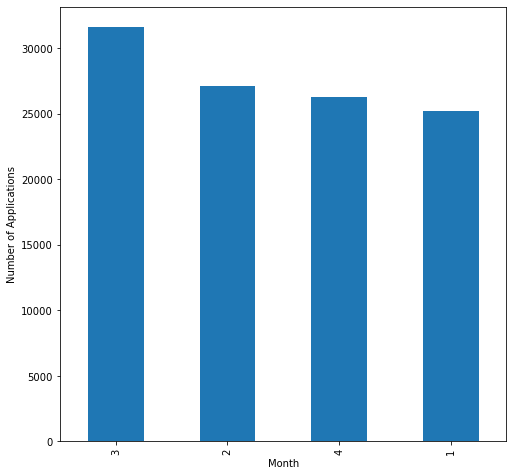

In [761]:
# посмотрим количество поданных заявок по месяцам
data['app_date'].dt.month.value_counts().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Applications')

In [762]:
# добавим новый признак app_month
data['app_month'] = data['app_date'].dt.month

In [763]:
# проверяем что признак добавлен
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   client_id         110148 non-null  int64         
 1   app_date          110148 non-null  datetime64[ns]
 2   education         110148 non-null  object        
 3   sex               110148 non-null  object        
 4   age               110148 non-null  int64         
 5   car               110148 non-null  object        
 6   car_type          110148 non-null  object        
 7   decline_app_cnt   110148 non-null  int64         
 8   good_work         110148 non-null  int64         
 9   score_bki         110148 non-null  float64       
 10  bki_request_cnt   110148 non-null  int64         
 11  region_rating     110148 non-null  int64         
 12  home_address      110148 non-null  int64         
 13  work_address      110148 non-null  int64         
 14  inco

In [764]:
# Сам признак app_data удалим, он нам больше не понадобится:
data = data.drop('app_date', axis=1)

In [765]:
# посмотрим на значения в строковых полях
cols = data.columns
for col in cols:
    if data[col].dtype == 'O':
        print('Уникальные значения в поле {0} : {1}'.format(
            col, data[col].unique()))

Уникальные значения в поле education : ['GRD' 'SCH' 'UGR' 'PGR' 'ACD']
Уникальные значения в поле sex : ['M' 'F']
Уникальные значения в поле car : ['Y' 'N']
Уникальные значения в поле car_type : ['Y' 'N']
Уникальные значения в поле foreign_passport : ['N' 'Y']


Строковые данные заполнены корректно, мусорных значений нет.

In [766]:
# смотрим размер всех данных
data.shape

(110148, 20)

In [767]:
# еще раз смотрим на данные
data.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month
1958,24897,GRD,M,28,N,N,0,0,-2.048202,0,40,1,1,15000,1,3,N,0,0,1
106237,36269,GRD,M,31,N,N,0,0,-1.910278,0,60,1,2,40000,4,1,N,1,0,2
72281,7280,SCH,F,49,N,N,2,0,-1.176932,1,50,2,3,35000,4,1,N,1,1,1


In [768]:
# распределяем признаки по категориям и проверяем, что все признаки вошли - ничего не пропустили
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport']  # 'default' исключили

cat_cols = [
    'education', 'region_rating', 'home_address', 'work_address', 'sna',
    'first_time', 'app_month'
]

num_cols = [
    'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income'
]  # client_id исключили из списка

ident_col = ['client_id']

target_col = ['default']

sample_col = ['sample']

len(bin_cols) + len(cat_cols) + len(num_cols) + \
    len(ident_col) + len(target_col) + len(sample_col)

20

In [769]:
# фиксируем распредление колонок для первой модели с данными
model_1 = [bin_cols, cat_cols, num_cols, ident_col, target_col, sample_col]
add_model(model_1, 'model_1')

In [770]:
# проверяем наличие данных в словаре
models

{'model_1': {'bin_cols': ['sex',
   'car',
   'car_type',
   'good_work',
   'foreign_passport'],
  'cat_cols': ['education',
   'region_rating',
   'home_address',
   'work_address',
   'sna',
   'first_time',
   'app_month'],
  'num_cols': ['age',
   'decline_app_cnt',
   'score_bki',
   'bki_request_cnt',
   'income'],
  'ident_col': ['client_id'],
  'target_col': ['default'],
  'sample_col': ['sample']}}

# Работа с числовыми перменными num_cols

## 'age'- возраст заемщика

Количество выбросов 

,low,high,all
0,0,0,0


Количество выбросов после log

,low,high,all
0,0,0,0


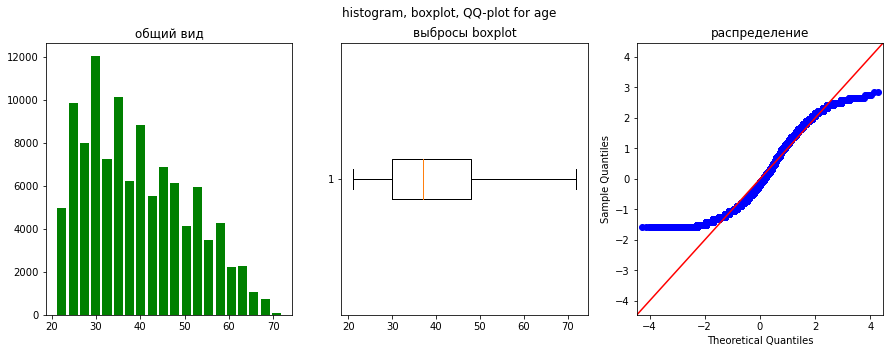

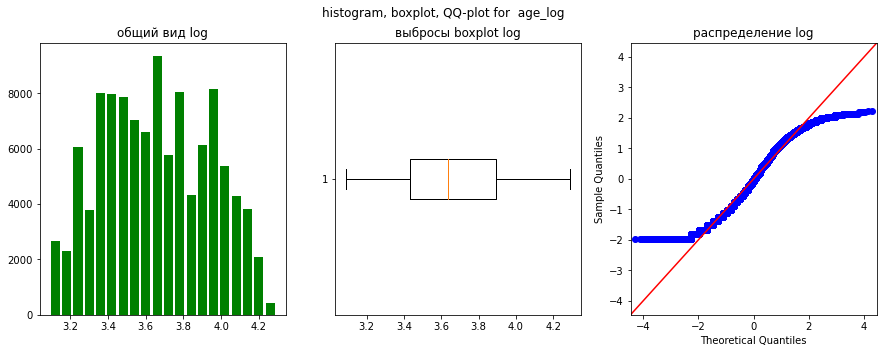

In [771]:
# столбец Age
InspectColumn(data, 'age')

In [772]:
# посмотрим распределение значение признака
data.age.value_counts(normalize=True)

31    0.037077
28    0.036633
30    0.036633
27    0.035988
29    0.035770
26    0.034317
32    0.034254
34    0.032211
33    0.031766
35    0.030740
25    0.029887
36    0.029306
37    0.028916
39    0.028099
38    0.027872
40    0.026782
42    0.025938
41    0.025457
24    0.025239
43    0.024258
44    0.023024
23    0.020836
45    0.020291
50    0.019102
46    0.019083
48    0.018920
47    0.018829
52    0.018748
51    0.018294
53    0.017976
49    0.017831
54    0.017349
55    0.016678
56    0.014898
57    0.014326
22    0.012846
58    0.012465
59    0.012165
21    0.011457
60    0.011221
61    0.008852
62    0.008035
63    0.006537
64    0.006019
65    0.005611
66    0.004013
67    0.003468
68    0.002370
69    0.000999
70    0.000545
71    0.000054
72    0.000018
Name: age, dtype: float64

Вывод: выбросов нет; распределение по возрасту при логарифмировании не сильно меняется, оставляем как есть.

## 'decline_app_cnt'- количество отказанных прошлых заявок

Количество выбросов 

,low,high,all
0,0,18677,18677


Количество выбросов после log

,low,high,all
0,0,18677,18677


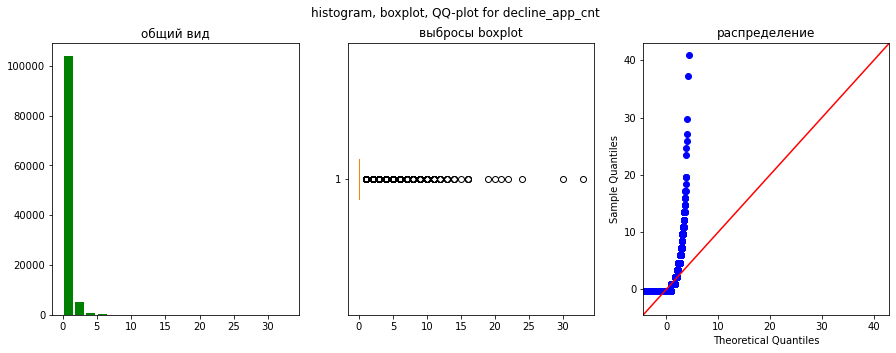

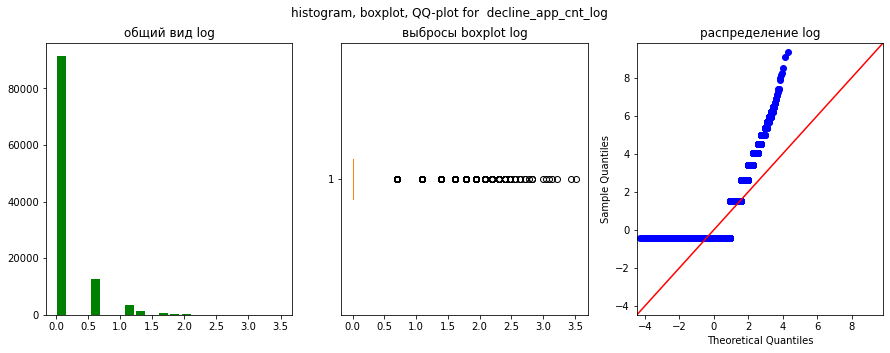

In [773]:
# посмотрим на decline_app_cnt
InspectColumn(data, 'decline_app_cnt')

Вывод: наличие выбросов большое, логарифмирование его не убрало, но распредление стало выглядеть лучше.
Посмотрим на само распределение признака.

In [774]:
# посмотрим распределение значение признака
data.decline_app_cnt.value_counts(normalize=True)

0     0.830437
1     0.113484
2     0.032883
3     0.012392
4     0.005502
5     0.002315
6     0.001416
7     0.000527
8     0.000336
9     0.000263
10    0.000145
11    0.000091
12    0.000045
13    0.000036
14    0.000027
16    0.000027
30    0.000009
15    0.000009
19    0.000009
20    0.000009
21    0.000009
22    0.000009
24    0.000009
33    0.000009
Name: decline_app_cnt, dtype: float64

Можно категоризировать данный признак, разбив его на классы: 
- 0 - 0 отказов; 
- 1 - 1 отказ, 
- 2 - 2 отказа, 
- 3 - 3 отказа, 
- 4 - более 3-х отказов

In [775]:
# 83% - это значение 0, т.е. в прошлом отказов не было.
# Перенесем этот признак в категориальные:
# 0 = 0; 1 = 1; 2 = 2; 3 = 3; 4 > 3 отказов
data.decline_app_cnt = data.decline_app_cnt.apply(lambda x: 4 if x > 3 else (
    3 if x == 3 else (2 if x == 2 else (1 if x == 1 else 0))))

In [776]:
# проверяем что признак изменился
data.decline_app_cnt.value_counts(normalize=True)

0    0.830437
1    0.113484
2    0.032883
3    0.012392
4    0.010804
Name: decline_app_cnt, dtype: float64

In [777]:
data.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month
29742,96364,GRD,M,40,N,N,0,0,-2.236047,1,60,1,3,30000,1,3,N,0,0,4
72545,81603,GRD,M,33,N,N,2,1,-1.117978,2,60,2,3,70000,2,3,N,1,1,3
10006,35979,SCH,F,37,Y,Y,0,1,-2.295223,5,80,2,3,60000,1,3,N,0,0,2
78882,61580,SCH,M,30,Y,N,0,0,-1.374821,2,40,2,3,20000,1,4,N,1,1,3
62922,99063,GRD,F,30,Y,N,0,0,-1.589724,0,80,2,3,50000,1,4,N,1,0,4


In [778]:
# исключаем из числовых, добавляем в категориальные
num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')
models['model_1']['num_cols'].remove('decline_app_cnt')
models['model_1']['cat_cols'].append('decline_app_cnt')

In [779]:
# проверяем список числовых признаков
models['model_1']['num_cols']

['age', 'score_bki', 'bki_request_cnt', 'income']

In [780]:
# проверяем список категориальных признаков 'decline_app_cnt'
models['model_1']['cat_cols']

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time',
 'app_month',
 'decline_app_cnt']

## 'score_bki' - скоринговый балл по данным из БКИ 

Количество выбросов 

,low,high,all
0,82,436,518


Количество выбросов после log

,low,high,all
0,130,0,130


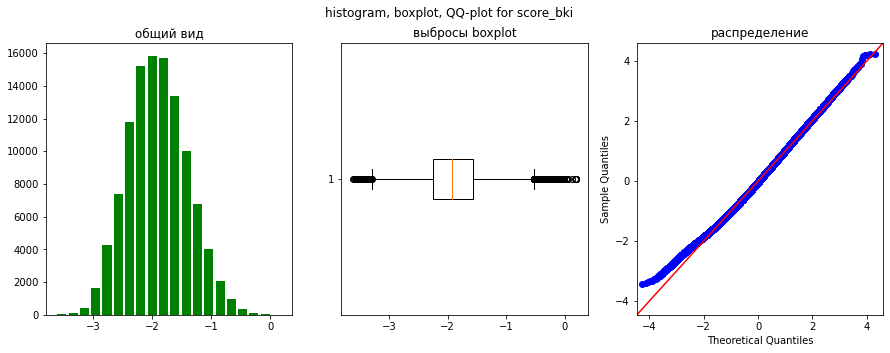

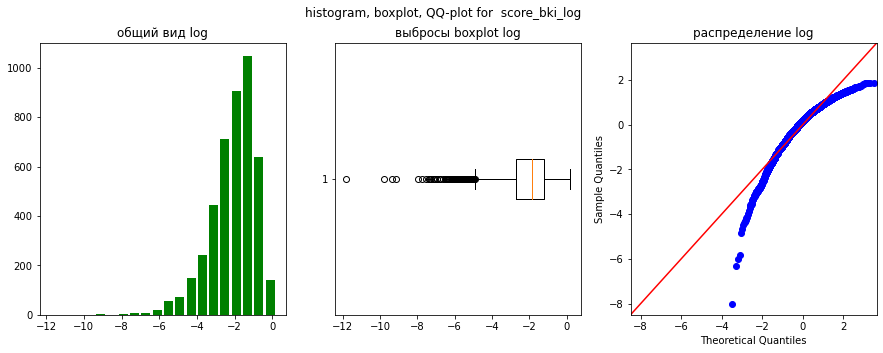

In [781]:
# смотрим следующий признак: score_bki
InspectColumn(data, 'score_bki')

In [782]:
# посмотрим распределение значение признака
data.score_bki.value_counts(normalize=True)

-1.775263    0.004694
-2.104211    0.004122
-2.225004    0.003849
-2.169664    0.003405
-2.024100    0.002524
               ...   
-1.916044    0.000009
-2.142259    0.000009
-1.227466    0.000009
-2.709566    0.000009
-2.295169    0.000009
Name: score_bki, Length: 102618, dtype: float64

Вывод: есть выбросы; после логарифмирования распредление сместилось вправо, выбросов стало меньше. Похоже, что скоринговый балл уже возвращают нормально распредлеленным, поэтому оставляем его как есть без изменений.

## 'bki_request_cnt' - количество запросов в БКИ

Количество выбросов 

,low,high,all
0,0,2636,2636


Количество выбросов после log

,low,high,all
0,0,15,15


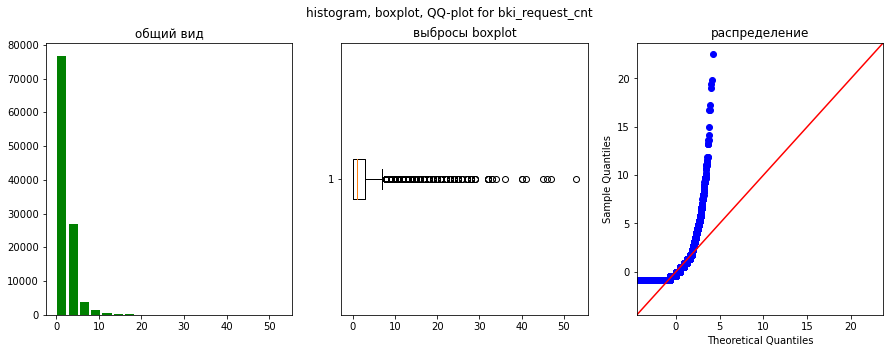

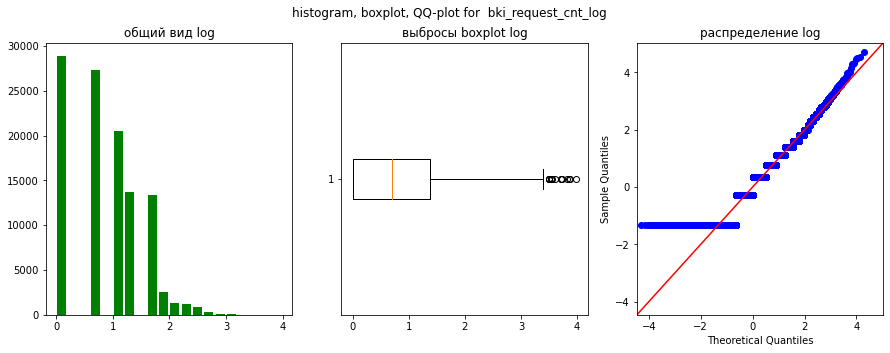

In [783]:
# У нас остались 'bki_request_cnt','income'. Смотрим на bki_request_cnt
InspectColumn(data, 'bki_request_cnt')

In [784]:
# посмотрим распределение значение признака
data.bki_request_cnt.value_counts(normalize=True)

0     0.262447
1     0.247803
2     0.185941
3     0.124106
4     0.076316
5     0.045030
6     0.022697
7     0.011730
8     0.006673
9     0.004167
10    0.003178
11    0.002524
12    0.001970
13    0.001371
14    0.000999
15    0.000735
16    0.000527
17    0.000300
18    0.000291
19    0.000272
21    0.000172
20    0.000127
23    0.000109
24    0.000109
22    0.000073
25    0.000045
27    0.000045
28    0.000045
26    0.000036
32    0.000036
29    0.000027
33    0.000018
40    0.000018
41    0.000009
46    0.000009
45    0.000009
47    0.000009
36    0.000009
34    0.000009
53    0.000009
Name: bki_request_cnt, dtype: float64

Вывод: выбросы уменьшились после логарифмирования признака, распредление тоже стало лучше. Заменять на категориальный признак не будем. Заменяем признак на его логарифм.

In [785]:
# заменяем признак на его логарифмированное значение
UseLogColumn(data, 'bki_request_cnt', num_cols)

In [786]:
# проверяем что в датасет добавилась логарифмированная колонка
data.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month,bki_request_cnt_log
7906,48629,SCH,M,27,Y,N,0,0,-2.300246,2,60,2,3,32200,1,4,N,0,0,2,1.098612
83410,23427,UGR,M,49,Y,Y,0,0,-1.716332,0,70,2,3,70000,1,3,N,1,0,1,0.000000
73262,66329,GRD,F,22,N,N,0,1,-1.954577,2,70,2,3,40000,1,1,N,1,0,3,1.098612


In [787]:
# проверяем что в списке числовых колонок исходная колонка удалилась, а логарифмированная вместо неё  добавилась
num_cols

['age', 'score_bki', 'income', 'bki_request_cnt_log']

## 'income' - доход заемщика

Количество выбросов 

,low,high,all
0,0,7000,7000


Количество выбросов после log

,low,high,all
0,875,1734,2609


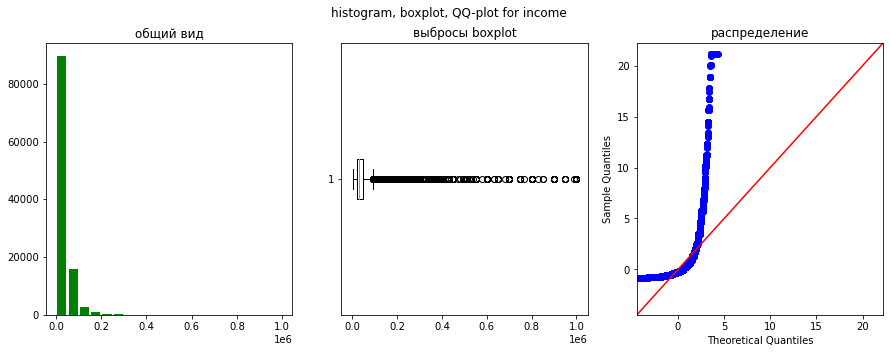

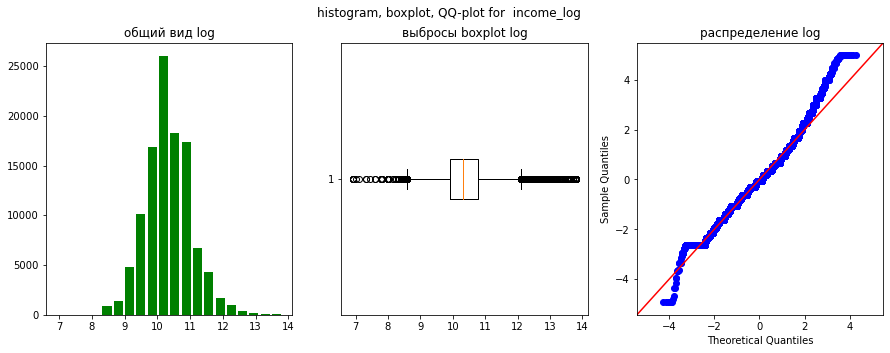

In [788]:
InspectColumn(data, 'income')

In [789]:
# посмотрим распределение значение признака
data.income.value_counts(normalize=True)

30000     0.094754
25000     0.082525
20000     0.074209
40000     0.067028
50000     0.061209
            ...   
27478     0.000009
27350     0.000009
20412     0.000009
23120     0.000009
426000    0.000009
Name: income, Length: 1207, dtype: float64

Вывод: доход заемщика тоже один из важных показателей. Есть выбросы, т.к. уровень доходов у всех разный. После логарифмирования распределение стало боле равномерным и выбросы тоже ущественно сократились. Поэтому заменяем признак на его логарифмическое значение.

In [790]:
# заменяем признак на его логарифмированное значение
UseLogColumn(data, 'income', num_cols)

In [791]:
# проверяем что в датасет добавилась логарифмированная колонка
data.sample(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month,bki_request_cnt_log,income_log
102701,65498,SCH,F,66,N,N,0,0,-2.218306,2,60,1,2,6500,4,1,N,1,0,3,1.098612,8.779711
14728,90631,SCH,F,58,N,N,0,0,-2.706926,5,50,2,3,12000,1,4,N,0,0,4,1.791759,9.392745
63941,98093,GRD,M,54,N,N,0,0,-2.072459,1,60,2,3,16000,1,2,N,1,0,4,0.693147,9.680406


In [792]:
# проверяем что в списке числовых колонок исходная колонка удалилась, а логарифмированная вместо неё  добавилась
num_cols

['age', 'score_bki', 'bki_request_cnt_log', 'income_log']

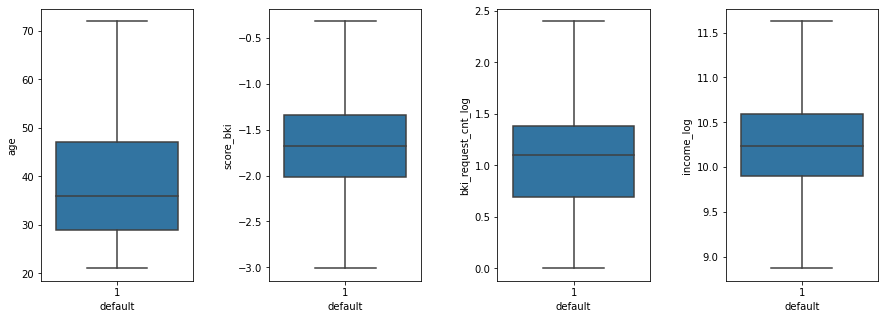

In [793]:
# строим boxplot’ы для численных переменных
df_default = data[data['default'] == 1]
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x='default',
                y=num_cols[i],
                data=df_default,
                orient='v',
                ax=axes[i],
                showfliers=False)

### Предварительныее выводы по количественным переменным:

Дефолтные клиенты в среднем ...

- младше 38 лет
- имеют средний бал БКИ -1.6
- имеют большое количество отмененных заявок
- имеют большое количество запросов в БКИ
- имет низкий доход

## Оценка корреляций

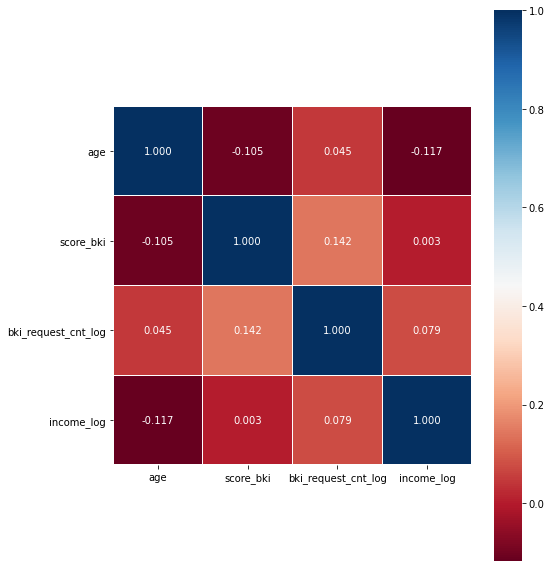

In [794]:
table_corr = data[num_cols].corr()

# вывод значений коррелций с подстветкой
plt.rcParams['figure.figsize'] = (8, 8)
sns.heatmap(table_corr,
            square=True,
            annot=True,
            fmt=".3f",
            linewidths=0.1,
            cmap="RdBu")
plt.tight_layout()

In [795]:
get_corr_value(table_corr)

ПОЛОЖИТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:

0.141599623514187 : score_bki - bki_request_cnt_log

СЛАБУЮ ПОЛОЖИТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:

0.07864948577415123 : bki_request_cnt_log - income_log
0.04519762289006033 : age - bki_request_cnt_log
0.002591902856654491 : score_bki - income_log

ОТРИЦАТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:

-0.11727363250541022 : age - income_log
-0.10468204702412096 : age - score_bki

СЛАБУЮ ОТРИЦАТЕЛЬНУЮ КОРРЕЛЯЦИЮ ИМЕЮТ:



### Вывод: 
список показателей:
- 'age'- возраст заемщика
- 'decline_app_cnt'- количество отказанных прошлых заявок
- 'score_bki' - скоринговый балл по данным из БКИ
- 'bki_request_cnt' - количество запросов в БКИ
- 'income' - доход заемщика

описание зависимостей:
- больших корреляций в  числовых данных не обнаружено, т.е. можно оставить все признаки для обучения.
- обнаружены зависисмости:
    - чем больше скоринговый балл БКИ - тем больше количество отказов
    - чем больше скоринговый балл БКИ - тем больше запросов в БКИ, т.е. заемщики - дефолтники чаще ходят по кредитным организациям (до переноса количества запросов в категориальные)
    - чем больше количество отказов тем больше запросов - ещё раз подтверждает настойчивость определенных заемщиков (до переноса количества запросов в категориальные)
    
    - чем больше возраст - тем меньше отказов
    - чем больше возраст - тем ниже доход
    - чем больше возраст - тем меньше скоринговый балл БКИ

## Значимость числовых переменных

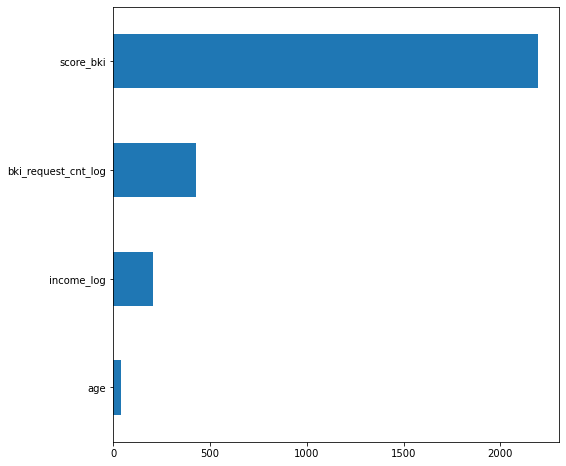

In [796]:
# посмотрим значимость числовых переменных для МО
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [797]:
# стандартизиуем числовые признаки
data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),
                        columns=num_cols)
data_num

,age,score_bki,bki_request_cnt_log,income_log
0,-0.889859,-0.735587,0.770563,0.680425
1,-0.021654,0.800039,0.333797,-2.624624
2,0.933372,0.426908,-0.281790,-0.052834
3,1.454295,-0.940432,-0.281790,-0.868125
4,-0.108474,-1.167347,-1.334144,1.937123
...,...,...,...,...
110143,0.499269,0.225214,0.770563,-0.868125
110144,0.151987,-0.307360,-0.281790,1.163415
110145,-0.716218,0.784750,1.109345,0.529186
110146,-0.889859,0.851432,0.770563,-1.253186


# Бинарные признаки

In [798]:
data[bin_cols]

,sex,car,car_type,good_work,foreign_passport
0,M,Y,Y,0,N
1,F,N,N,0,N
2,M,Y,Y,0,Y
3,M,N,N,0,N
4,F,N,N,0,N
...,...,...,...,...,...
110143,F,N,N,0,N
110144,M,Y,Y,0,N
110145,M,N,N,0,N
110146,F,N,N,1,N


In [799]:
# закодируем их
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

# убедимся в преобразовании
data[bin_cols].sample(5)

,sex,car,car_type,good_work,foreign_passport
8190,1,1,1,0,0
47961,0,0,0,0,0
3658,1,0,0,1,0
68439,1,1,1,0,1
108743,1,0,0,1,0


In [878]:
data_bin = data[bin_cols]

# Категориальные признаки

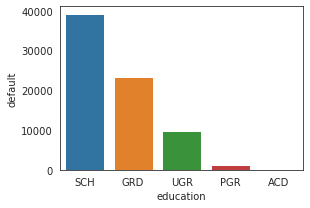

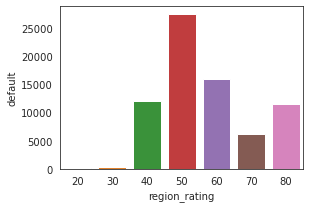

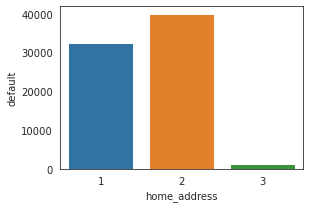

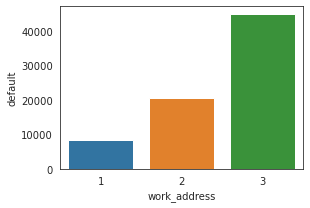

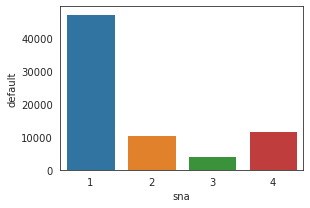

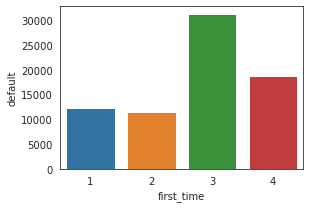

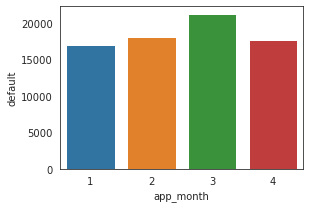

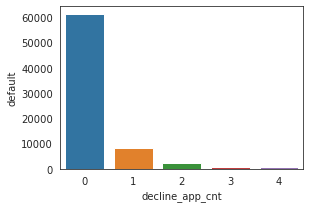

In [800]:
# визуализация категориальных признаков
for i in cat_cols:
    f = plt.figure(figsize=(15, 3))
    gs = f.add_gridspec(1, 4)
    with sns.axes_style("white"):
        ax = f.add_subplot(gs[0, 0])
        sns.barplot(x=i,
                    y='default',
                    data=data[data['sample'] == 1],
                    estimator=len)
    f.tight_layout()

In [801]:
# заменим строковые значения в столбце education на числовые
enc_edu = LabelEncoder()
enc_edu.fit(data['education'])
data['education'] = enc_edu.transform(data['education'])

In [802]:
data[cat_cols]

,education,region_rating,home_address,work_address,sna,first_time,app_month,decline_app_cnt
0,1,50,1,2,1,4,3,0
1,3,50,1,2,4,3,1,4
2,4,50,1,2,1,3,3,0
3,3,40,1,2,1,3,2,0
4,1,80,2,3,1,3,2,0
...,...,...,...,...,...,...,...,...
110143,1,50,1,2,4,4,3,0
110144,3,50,2,2,1,4,3,0
110145,3,80,2,3,2,2,4,0
110146,3,50,1,3,2,3,1,0


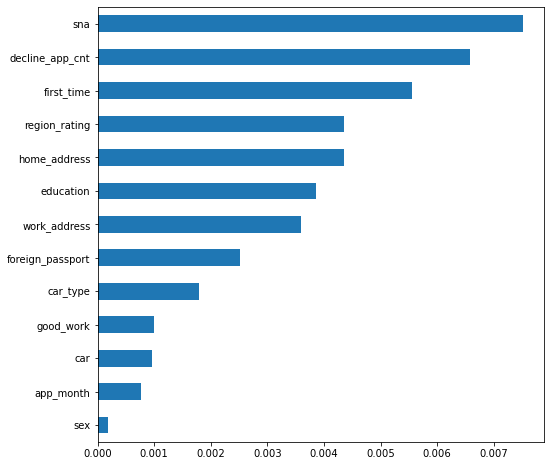

In [803]:
# посмотрим значимость признаков и бинарных и категориальных
imp_cat = Series(mutual_info_classif(data[data['sample'] == 1][bin_cols +
                                                               cat_cols],
                                     data[data['sample'] == 1]['default'],
                                     discrete_features=True),
                 index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [804]:
data.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month,bki_request_cnt_log,income_log
14828,78985,3,0,51,0,0,0,0,-2.124552,0,50,1,1,7000,1,3,0,0,0,3,0.000000,8.853808
20618,3594,4,1,37,1,1,0,1,-2.428238,3,40,2,3,45000,1,2,0,0,0,1,1.386294,10.714440
30668,12441,1,0,38,0,0,0,1,-1.941585,3,80,2,3,50000,4,1,0,0,0,1,1.386294,10.819798
86493,80529,3,1,39,1,0,0,0,-2.439379,0,50,2,3,40000,1,4,0,1,0,3,0.000000,10.596660
47143,53489,3,0,35,0,0,0,0,-1.789848,1,70,1,3,30000,1,1,1,1,0,3,0.693147,10.308986


In [805]:
# закодируем категориальные признаки при помощи get_dummy
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns=cat_cols)
cat_cols = data_cat.columns.tolist()
cat_cols

['education_0',
 'education_1',
 'education_2',
 'education_3',
 'education_4',
 'region_rating_20',
 'region_rating_30',
 'region_rating_40',
 'region_rating_50',
 'region_rating_60',
 'region_rating_70',
 'region_rating_80',
 'home_address_1',
 'home_address_2',
 'home_address_3',
 'work_address_1',
 'work_address_2',
 'work_address_3',
 'sna_1',
 'sna_2',
 'sna_3',
 'sna_4',
 'first_time_1',
 'first_time_2',
 'first_time_3',
 'first_time_4',
 'app_month_1',
 'app_month_2',
 'app_month_3',
 'app_month_4',
 'decline_app_cnt_0',
 'decline_app_cnt_1',
 'decline_app_cnt_2',
 'decline_app_cnt_3',
 'decline_app_cnt_4']

- bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport'] # 'default' исключили
- cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'app_month']
- num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income'] # client_id исключили из списка
- ident_col = ['client_id']
- target_col = ['default']
- sample_col = ['sample']


# Построение и обучение модели


## Построение модели на исходных данных без пропусков

In [806]:
# получаем исходный дата сет без пропусков
data_1 = pd.concat([
    data[ident_col], data[models['model_1']['num_cols']],
    data[models['model_1']['cat_cols']], data[models['model_1']['bin_cols']],
    data[target_col], data[sample_col]
],
    axis=1)
data_1

,client_id,age,score_bki,bki_request_cnt,income,education,region_rating,home_address,work_address,sna,first_time,app_month,decline_app_cnt,sex,car,car_type,good_work,foreign_passport,default,sample
0,74835,29,-2.271884,3,50000,1,50,1,2,1,4,3,0,1,1,1,0,0,0,0
1,17527,39,-1.504999,2,5000,3,50,1,2,4,3,1,4,0,0,0,0,0,0,0
2,75683,50,-1.691339,1,30000,4,50,1,2,1,3,3,0,1,1,1,0,1,0,0
3,26883,56,-2.374182,1,17000,3,40,1,2,1,3,2,0,1,0,0,0,0,0,0
4,28862,38,-2.487502,0,120000,1,80,2,3,1,3,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,45,-1.792064,3,17000,1,50,1,2,4,4,3,0,0,0,0,0,0,0,1
110144,76821,41,-2.058029,1,70000,3,50,2,2,1,4,3,0,1,1,1,0,0,0,1
110145,103695,31,-1.512635,4,45000,3,80,2,3,2,2,4,0,1,0,0,0,0,0,1
110146,861,29,-1.479334,3,13000,3,50,1,3,2,3,1,0,0,0,0,1,0,1,1


In [807]:
# фиксируем датасет для первой МО
models['model_1']['data'] = data_1

In [808]:
# разделим снова на train_df и test_df
train_data_1 = data_1[data_1['sample'] == 1].drop(['sample'], axis=1)
test_data_1 = data_1[data_1['sample'] == 0].drop(['sample'], axis=1)

In [809]:
X_1 = train_data_1.drop(['default', 'client_id'], axis=1).values
y_1 = train_data_1['default'].values

# фиксируем значения X, y для первой модели
models['model_1']['X'] = X_1
models['model_1']['y'] = y_1

In [810]:
# разделим train_data_1 на тренировочные и валидационные выборки
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    X_1, y_1, test_size=0.20, random_state=RANDOM_SEED)

# фиксируем выборки для первой модели
models['model_1']['X_train'] = X_train_1
models['model_1']['X_test'] = X_test_1
models['model_1']['y_train'] = y_train_1
models['model_1']['y_test'] = y_test_1

In [811]:
lr_1 = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)
lr_1.fit(X_train_1, y_train_1)

# фиксируем модель для первой модели
models['model_1']['model'] = lr_1

In [812]:
# получаем предсказанные значения для первой модели
probs_1 = lr_1.predict_proba(X_test_1)
y_pred_probs_1 = probs_1[:, 1]
y_pred_1 = lr_1.predict(X_test_1)

# фиксируем  предсказанные значения для первой модели
models['model_1']['y_pred_proba'] = y_pred_probs_1
models['model_1']['y_pred'] = y_pred_1

In [813]:
# посмотрим метрики
summary_metrics(summary, 'model_1', y_test_1, y_pred_1, y_pred_probs_1)

,model_1
Accuracy,0.876220
Precision,0.000000
Recall,0.000000
F1,0.000000
Roc_Auc,0.583501
M_Conf_TP,0.000000
M_Conf_FP,0.000000
M_Conf_TN,12933.000000
M_Conf_FN,1827.000000


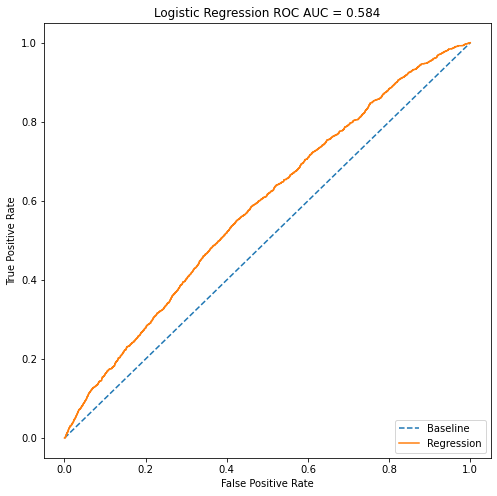

In [814]:
# построим кривую roc
roc_auc_curve(y_test_1, y_pred_probs_1)

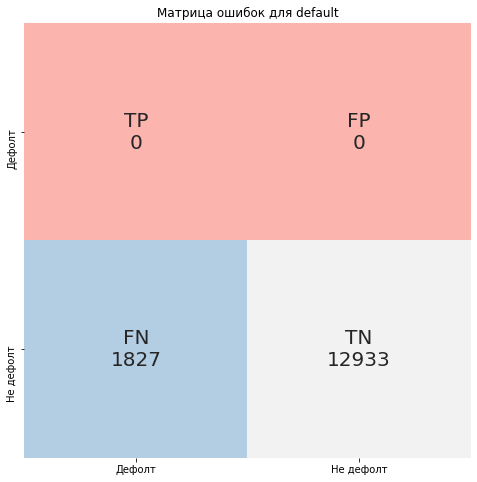

In [815]:
# и выведем confusion matrix
confusion_matrix_plot(y_test_1, y_pred_1)

Вывод: Можно сказать, что на сырых данных модель не работает совсем, несмотря на высокую метрику Accuracy = 0.876220;  Roc_Auc = 0.583501  - позитивный класс не предсказывается совсем.

## Построение модели после EDA

In [816]:
# собираем датасет из обработанныз признаков
data_2 = pd.concat([
    data[ident_col], data_num, data_cat, data_bin, data[target_col],
    data[sample_col]
],
    axis=1)
data_2

,client_id,age,score_bki,bki_request_cnt_log,income_log,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,app_month_1,app_month_2,app_month_3,app_month_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4,sex,car,car_type,good_work,foreign_passport,default,sample
0,74835,-0.889859,-0.735587,0.770563,0.680425,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0
1,17527,-0.021654,0.800039,0.333797,-2.624624,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,75683,0.933372,0.426908,-0.281790,-0.052834,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,1,0,1,0,0
3,26883,1.454295,-0.940432,-0.281790,-0.868125,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,28862,-0.108474,-1.167347,-1.334144,1.937123,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,0.499269,0.225214,0.770563,-0.868125,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
110144,76821,0.151987,-0.307360,-0.281790,1.163415,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1
110145,103695,-0.716218,0.784750,1.109345,0.529186,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1
110146,861,-0.889859,0.851432,0.770563,-1.253186,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1


In [817]:
# разделим снова на train_df и test_df
train_data_2 = data_2[data_2['sample'] == 1].drop(['sample'], axis=1)
test_data_2 = data_2[data_2['sample'] == 0].drop(['sample'], axis=1)

In [818]:
X_2 = train_data_2.drop(['default', 'client_id'], axis=1).values
y_2 = train_data_2['default'].values

In [819]:
# разделим на тренировочные и валидационные выборки
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, test_size=0.20, random_state=RANDOM_SEED)

In [820]:
lr_2 = LogisticRegression(random_state=RANDOM_SEED, max_iter=1000)

In [821]:
lr_2.fit(X_train_2, y_train_2)

LogisticRegression(max_iter=1000, random_state=42)

In [822]:
probs_2 = lr_2.predict_proba(X_test_2)
y_pred_probs_2 = probs_2[:, 1]

y_pred_2 = lr_2.predict(X_test_2)

In [823]:
# фиксируем распредление колонок для второй модели с данными
model_2 = [
    bin_cols, cat_cols, num_cols, ident_col, target_col, sample_col, data_2,
    lr_2, y_2, X_2, X_train_2, X_test_2, y_train_2, y_test_2, y_pred_2,
    y_pred_probs_2
]
add_model(model_2, 'model_2')

In [824]:
# посмотрим метрики
summary_metrics(summary, 'model_2', y_test_2, y_pred_2, y_pred_probs_2)

,model_1,model_2
Accuracy,0.876220,0.874729
Precision,0.000000,0.396226
Recall,0.000000,0.022989
F1,0.000000,0.043456
Roc_Auc,0.583501,0.744614
M_Conf_TP,0.000000,42.000000
M_Conf_FP,0.000000,64.000000
M_Conf_TN,12933.000000,12869.000000
M_Conf_FN,1827.000000,1785.000000


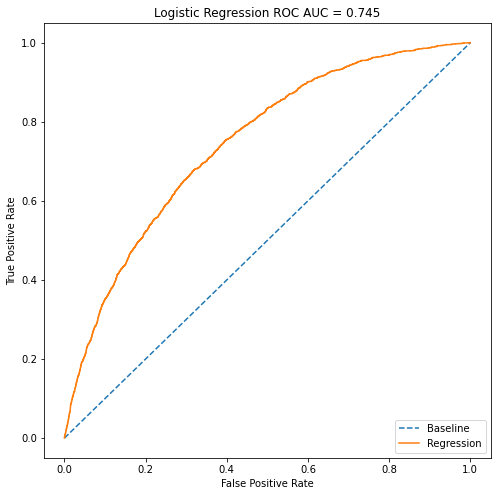

In [825]:
# построим кривую roc
roc_auc_curve(y_test_2, y_pred_probs_2)

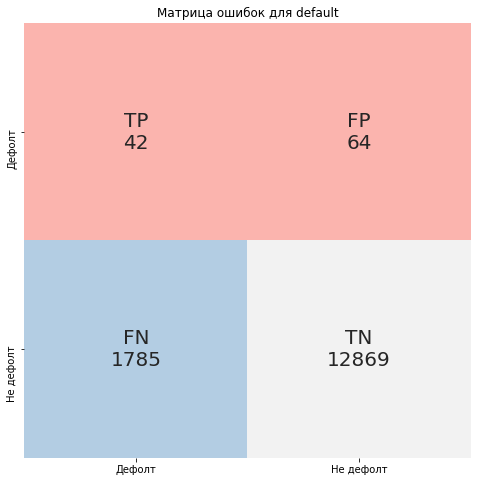

In [826]:
# и выведем confusion matrix
confusion_matrix_plot(y_test_2, y_pred_2)

Преобразование данных, их нормализация уже дала всем метрикам значения отличные от нуля и модель уже стала предсказывать позитивный класс, но пока ещё очень плохо.

Попробуем улучшить модель, подобрав оптимальные параметры 

## Балансировка: class_weight = 'balanced'

Text(0.5, 1.0, 'Баланс целефой переменной default ')

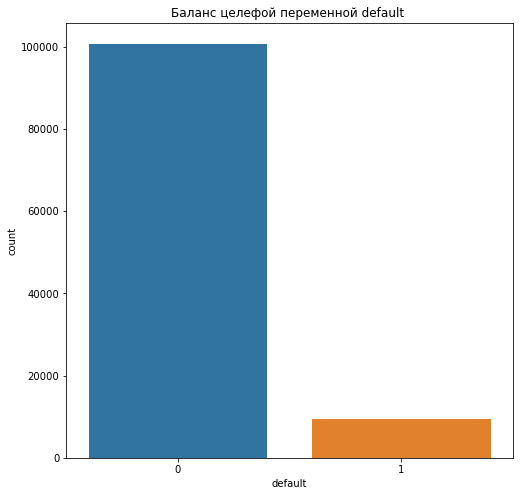

In [827]:
# посмотрим на распределение классов по default
ax = sns.countplot(x="default", data=data_2)
ax.set_title("Баланс целефой переменной default ")

In [828]:
class_0 = len(y_train_2[y_train_2 == 0])
class_1 = len(y_train_2[y_train_2 == 1])
print('класс 0: ', class_0)
print('класс 1: ', class_1)

класс 0:  51494
класс 1:  7545


In [829]:
print('класс 0 / class_1: ', round(class_0 / class_1, 2))

класс 0 / class_1:  6.82


Видим дисбалан между классами почти в 7 раз.
Применим параметр модели **class_weight = 'balanced'** - параметр для балансировки классов, чтобы сделать нашу выборку сбалансированной.

In [830]:
lr_3 = LogisticRegression(class_weight='balanced',
                          max_iter=2000,
                          random_state=RANDOM_SEED)
lr_3.fit(X_train_2, y_train_2)

probs_3 = lr_3.predict_proba(X_test_2)
y_pred_probs_3 = probs_3[:, 1]

y_pred_3 = lr_3.predict(X_test_2)

In [831]:
# фиксируем распредление колонок для второй модели с данными
model_3 = [
    bin_cols, cat_cols, num_cols, ident_col, target_col, sample_col, data_2,
    lr_3, y_2, X_2, X_train_2, X_test_2, y_train_2, y_test_2, y_pred_3,
    y_pred_probs_3
]
add_model(model_3, 'model_3')

In [832]:
# сравним метрики с предыдущей моделью
summary_metrics(summary, 'model_3', y_test_2, y_pred_3, y_pred_probs_3)

,model_1,model_2,model_3
Accuracy,0.876220,0.874729,0.670935
Precision,0.000000,0.396226,0.225742
Recall,0.000000,0.022989,0.682540
F1,0.000000,0.043456,0.339274
Roc_Auc,0.583501,0.744614,0.744263
M_Conf_TP,0.000000,42.000000,1247.000000
M_Conf_FP,0.000000,64.000000,4277.000000
M_Conf_TN,12933.000000,12869.000000,8656.000000
M_Conf_FN,1827.000000,1785.000000,580.000000


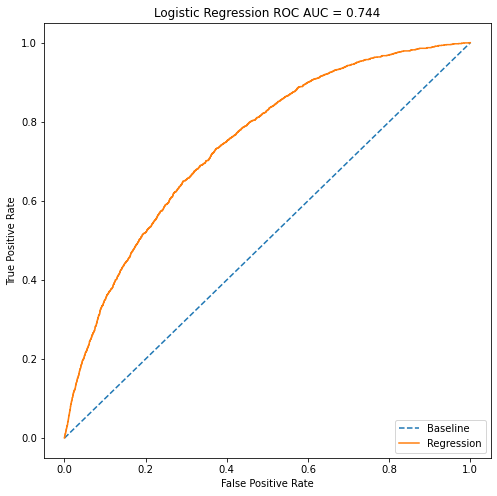

In [833]:
# построим кривую roc
roc_auc_curve(y_test_2, y_pred_probs_3)

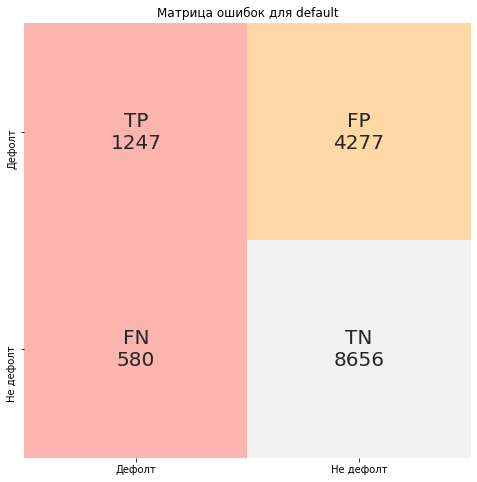

In [834]:
# и выведем confusion matrix
confusion_matrix_plot(y_test_2, y_pred_3)

Вывод: Recall и f1 существенно выросли, confusion_matrix стала лучше, что говорит о том, что модель реально начала работать, но пока ещё недостаточно хорошо. Попробуем улучшить модель подборкой гиперпараметров, т.е. регуляризацией.

## Подбор параметров (регуляризация)

In [835]:
# попробуем подобрать параметры

C = np.logspace(-1, 3, 10)
iter_ = 1000
epsilon_stop = 1e-3

hyperparameters = [
    {
        'penalty': ['l1'],
        'C': C,
        'solver': ['liblinear', 'saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['l2'],
        'C': C,
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['none'],
        'C': C,
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
    {
        'penalty': ['elasticnet'],
        'C': C,
        'solver': ['saga'],
        'multi_class': ['auto', 'ovr'],
        'max_iter': [iter_],
        'tol': [epsilon_stop]
    },
]

model = LogisticRegression(class_weight='balanced', random_state=RANDOM_SEED)

In [836]:
# Обучаем модель и ищем лучшие параметры обучения модели
gridsearch = GridSearchCV(model,
                          hyperparameters,
                          scoring='f1',
                          n_jobs=-1,
                          cv=5)
gridsearch.fit(X_train_2, y_train_2)
model_best_params = gridsearch.best_estimator_

# Печатаем параметры
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:')
for param_name in best_params.keys():
    print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 5.994842503189409,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 1000,
  multi_class = auto,
  n_jobs = None,
  penalty = l2,
  random_state = 42,
  solver = lbfgs,
  tol = 0.001,
  verbose = 0,
  warm_start = False,


In [837]:
# обучаем модель с лучшими подобранными параметрами
lr_4 = LogisticRegression(C=5.994842503189409,
                          class_weight='balanced',
                          dual=False,
                          fit_intercept=True,
                          intercept_scaling=1,
                          l1_ratio=None,
                          max_iter=1000,
                          multi_class='auto',
                          n_jobs=None,
                          penalty='l2',
                          random_state=42,
                          solver='lbfgs',
                          tol=0.001,
                          verbose=0,
                          warm_start=False)

In [838]:
lr_4.fit(X_train_2, y_train_2)

LogisticRegression(C=5.994842503189409, class_weight='balanced', max_iter=1000,
                   random_state=42, tol=0.001)

In [839]:
probs_4 = lr_4.predict_proba(X_test_2)
y_pred_probs_4 = probs_4[:, 1]

y_pred_4 = lr_4.predict(X_test_2)

In [840]:
# фиксируем распредление колонок для второй модели с данными
model_4 = [
    bin_cols, cat_cols, num_cols, ident_col, target_col, sample_col, data_2,
    lr_4, y_2, X_2, X_train_2, X_test_2, y_train_2, y_test_2, y_pred_4,
    y_pred_probs_4
]
add_model(model_4, 'model_4')

In [841]:
# сравним метрики с предыдущей моделью
summary_metrics(summary, 'model_4', y_test_2, y_pred_4, y_pred_probs_4)

,model_1,model_2,model_3,model_4
Accuracy,0.876220,0.874729,0.670935,0.671003
Precision,0.000000,0.396226,0.225742,0.225783
Recall,0.000000,0.022989,0.682540,0.682540
F1,0.000000,0.043456,0.339274,0.339320
Roc_Auc,0.583501,0.744614,0.744263,0.744236
M_Conf_TP,0.000000,42.000000,1247.000000,1247.000000
M_Conf_FP,0.000000,64.000000,4277.000000,4276.000000
M_Conf_TN,12933.000000,12869.000000,8656.000000,8657.000000
M_Conf_FN,1827.000000,1785.000000,580.000000,580.000000


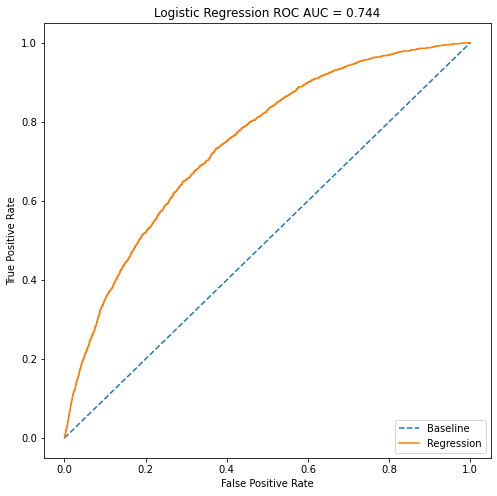

In [842]:
roc_auc_curve(y_test_2, y_pred_probs_4)

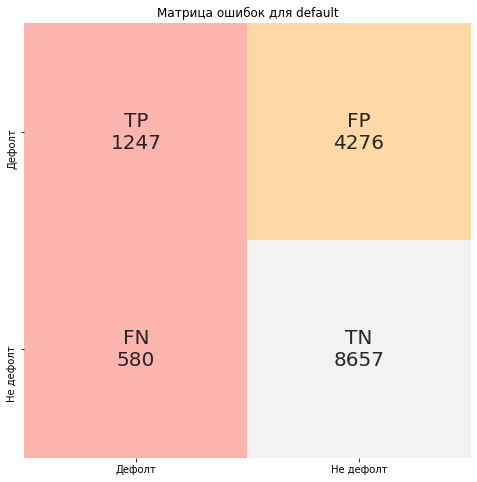

In [843]:
# и выведем confusion matrix
confusion_matrix_plot(y_test_2, y_pred_4)

Вывод: после подбора гиперпараметров Recall остался таким же, Roc_Auc немного уменьшился, остальные метрики стали немного больше. Модель стала намного лучше предсказывать дефолтных клиентов, но хуже угадывать тех, кто не дефолтный.

Рекомендовано использовать библиотеку LogisticRegressionCV - она работает хорошо без подбора гиперпараметров, попробуем обучить модель на ней.

## LogisticRegressionCV

In [844]:
C_cv = np.logspace(-4, 4, 10)
lr_5 = LogisticRegressionCV(
    Cs=C_cv,
    cv=5,
    scoring='f1',
    solver='saga',
    tol=0.0001,
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
)

lr_5.fit(X_train_2, y_train_2)

LogisticRegressionCV(Cs=array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, max_iter=1000, n_jobs=-1,
                     random_state=42, scoring='f1', solver='saga')

In [845]:
probs_5 = lr_5.predict_proba(X_test_2)
y_pred_probs_5 = probs_5[:, 1]

y_pred_5 = lr_5.predict(X_test_2)

In [846]:
# фиксируем распредление колонок для второй модели с данными
model_5 = [
    bin_cols, cat_cols, num_cols, ident_col, target_col, sample_col, data_2,
    lr_4, y_2, X_2, X_train_2, X_test_2, y_train_2, y_test_2, y_pred_5,
    y_pred_probs_5
]
add_model(model_5, 'model_5')

In [847]:
# сравним метрики с предыдущей моделью
summary_metrics(summary, 'model_5', y_test_2, y_pred_5, y_pred_probs_5)

,model_1,model_2,model_3,model_4,model_5
Accuracy,0.876220,0.874729,0.670935,0.671003,0.671070
Precision,0.000000,0.396226,0.225742,0.225783,0.225824
Recall,0.000000,0.022989,0.682540,0.682540,0.682540
F1,0.000000,0.043456,0.339274,0.339320,0.339366
Roc_Auc,0.583501,0.744614,0.744263,0.744236,0.744234
M_Conf_TP,0.000000,42.000000,1247.000000,1247.000000,1247.000000
M_Conf_FP,0.000000,64.000000,4277.000000,4276.000000,4275.000000
M_Conf_TN,12933.000000,12869.000000,8656.000000,8657.000000,8658.000000
M_Conf_FN,1827.000000,1785.000000,580.000000,580.000000,580.000000


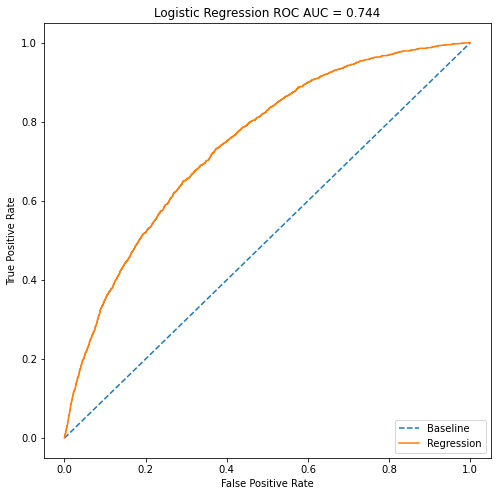

In [848]:
roc_auc_curve(y_test_2, y_pred_probs_5)

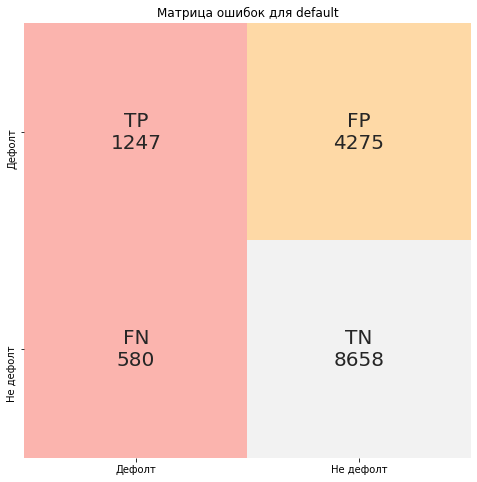

In [849]:
# и выведем confusion matrix
confusion_matrix_plot(y_test_2, y_pred_5)

Вывод: Модели 3 (балансировка), 4 (подбор гипрепараметров) и 5 (lr_cv) примерно одинаково работают. Метрики стали лучше, но пользоваться этой моделью всё ещё нельзя. Необходимо модель обогощать новыми данными. Попробуем это сделать на базе существующих данных.

## Создание новых признаков на базе имеющихся


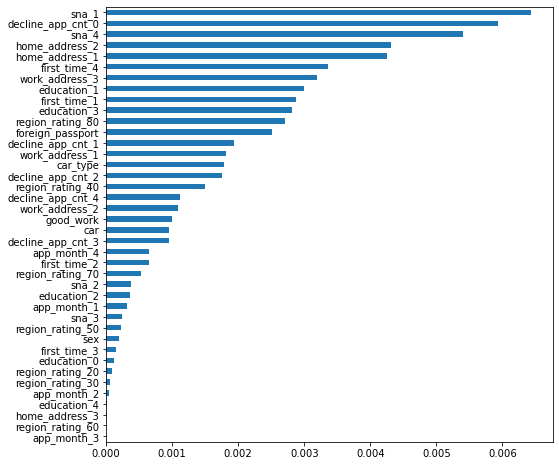

In [850]:
# посмотрим ещё раз на значимость признаков и бинарных и категориальных
imp_cat = Series(mutual_info_classif(data_2[data_2['sample'] == 1][bin_cols +
                                                                   cat_cols],
                                     data_2[data_2['sample'] == 1]['default'],
                                     discrete_features=True),
                 index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

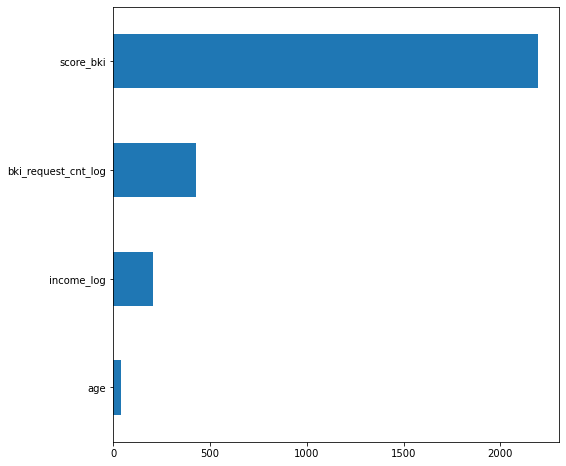

In [851]:
# посмотрим значимость числовых переменных для МО
imp_num = Series(f_classif(data_2[num_cols], data_2['default'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Видим, что важными признаками для обучения являются:
- **sna** - родственные связи
- **score_bki** - скоринговый балл БКИ

Попробуем предположить:

- жители опредленных районов имеют в среднем одинаковый достаток  потому ценными признаками могут быть:
    - **work_adress** - место работы
    - **home_adress** - место проживания
    - **region_raiting** - может в целом давать характеристику району и проживающих там
- **'age'** - мы также отметили, что возраст, хоть  модель обучения и не считает важным признаком, имеет корреляцию и в среднем люди младще 38 лет чаще являются дефолтниками. Поэтому **'age' надо включить в расчёт всех новых признаков**.
- **foreign_passport** наличие загранпаспорта также может косвено свидетельствовать о состоятельности клиента, ведь не все доходы официальные, а путешествия за границу дорого обходится.

На основе этих данных попрубуем ввести новые признаки:
- bki_age_region = score_bki / age * region_raiting
- bki_age_work_address = score_bki / age * work_address
- bki_age_home_address = score_bki / age * home_address
- bki_age_sna = (score_bki / age)^sna
- bki_age_foreign_passport = (score_bki / age)^foreign_passport

в теории говорилось, что иногда возведение в квадрат(степень) тоже даёт какие-то результаты.

In [852]:
data['bki_age_region'] = (data['score_bki'] /
                          data['age']) * data['region_rating']
# экспериментально эти метрики не надо создавать - модель ухудшается
# data['bki_age_work_address'] = (data['score_bki'] /
#                                data['age']) * data['work_address']
# data['bki_age_home_address'] = (data['score_bki'] /
#                                data['age']) * data['home_address']
data['bki_age_sna'] = (data['score_bki'] / data['age'])**data['sna']
data['bki_age_foreign_passport'] = (data['score_bki'] /
                                    data['age'])**data['foreign_passport']

In [853]:
data.sample(5)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,app_month,bki_request_cnt_log,income_log,bki_age_region,bki_age_sna,bki_age_foreign_passport
97483,92308,3,1,55,0,0,0,0,-2.184361,2,70,2,3,80000,1,4,1,1,1,4,1.098612,11.289794,-2.780096,-0.039716,-0.039716
101993,2245,3,0,39,0,0,0,0,-1.909253,2,80,2,3,65000,1,4,0,1,0,1,1.098612,11.082158,-3.916417,-0.048955,1.000000
95193,72106,4,1,33,1,1,0,0,-1.720322,2,50,1,2,27000,2,3,0,1,0,3,1.098612,10.203629,-2.606549,0.002718,1.000000
26711,11583,3,1,43,1,1,0,0,-1.572318,0,60,1,2,25000,3,2,0,0,0,1,0.000000,10.126671,-2.193932,-0.000049,1.000000
58805,39849,3,1,31,1,1,2,0,-1.790615,1,60,2,3,45000,4,1,0,1,0,2,0.693147,10.714440,-3.465707,0.000011,1.000000


Так как данные на этапе EDA уже были подготовлены, то новые признаки тоже будем считать тоже уже подготовленными, потому рассматривать их отдельно не будем. Посмотрим только один из новых признаков, чтобы убедиться, что обрабатывать новые признаки не стоит.

Количество выбросов 

,low,high,all
0,6,0,6


Количество выбросов после log

,low,high,all
0,20,0,20


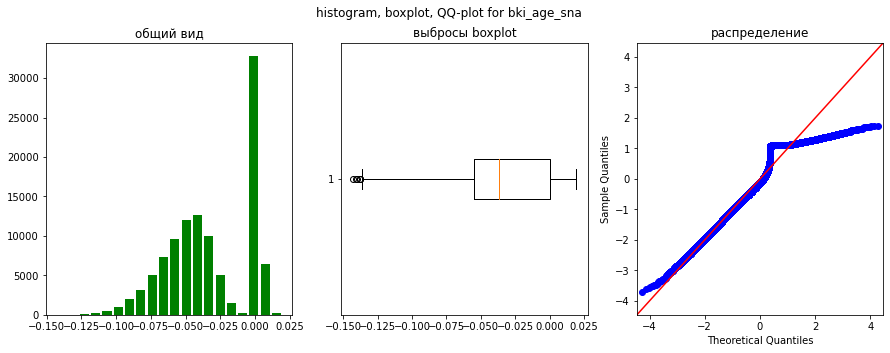

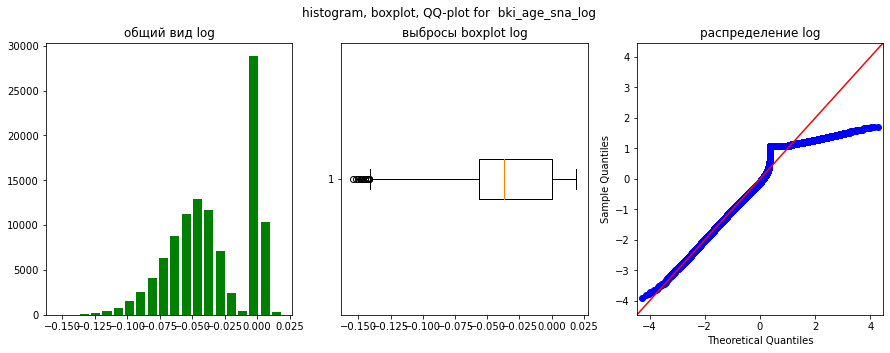

In [859]:
# столбец bki_age_region
InspectColumn(data, 'bki_age_sna')

In [860]:
# просматриваем ещё раз числовые колонки
num_cols

['age', 'score_bki', 'bki_request_cnt_log', 'income_log']

In [861]:
# добавми к ним созданные новые признаки
num_cols.append('bki_age_region')
# экспериментально эти метрики не надо создавать - модель ухудшается
# num_cols.append('bki_age_work_address')
# num_cols.append('bki_age_home_address')
num_cols.append('bki_age_sna')
num_cols.append('bki_age_foreign_passport')

In [862]:
# просматриваем ещё раз числовые колонки
num_cols

['age',
 'score_bki',
 'bki_request_cnt_log',
 'income_log',
 'bki_age_region',
 'bki_age_sna',
 'bki_age_foreign_passport']

In [863]:
# стандартизиуем числовые признаки
data_num_3 = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]),
                          columns=num_cols)
data_num_3

,age,score_bki,bki_request_cnt_log,income_log,bki_age_region,bki_age_sna,bki_age_foreign_passport
0,-0.889859,-0.735587,0.770563,0.680425,-0.671810,-1.525685,0.418574
1,-0.021654,0.800039,0.333797,-2.624624,0.766398,1.100738,0.418574
2,0.933372,0.426908,-0.281790,-0.052834,0.938723,-0.033367,-2.334280
3,1.454295,-0.940432,-0.281790,-0.868125,0.935463,-0.320651,0.418574
4,-0.108474,-1.167347,-1.334144,1.937123,-1.626831,-1.093879,0.418574
...,...,...,...,...,...,...,...
110143,0.499269,0.225214,0.770563,-0.868125,0.721754,1.100748,0.418574
110144,0.151987,-0.307360,-0.281790,1.163415,0.346485,-0.582134,0.418574
110145,-0.716218,0.784750,1.109345,0.529186,-0.662065,1.180483,0.418574
110146,-0.889859,0.851432,0.770563,-1.253186,0.316974,1.187901,0.418574


In [864]:
# собираем датасет из обработанныз признаков
data_3 = pd.concat([
    data[ident_col], data_num_3, data_cat, data_bin, data[target_col],
    data[sample_col]
],
                   axis=1)
data_3

,client_id,age,score_bki,bki_request_cnt_log,income_log,bki_age_region,bki_age_sna,bki_age_foreign_passport,education_0,education_1,education_2,education_3,education_4,region_rating_20,region_rating_30,region_rating_40,region_rating_50,region_rating_60,region_rating_70,region_rating_80,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,work_address_3,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,app_month_1,app_month_2,app_month_3,app_month_4,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,decline_app_cnt_3,decline_app_cnt_4,sex,car,car_type,good_work,foreign_passport,default,sample
0,74835,-0.889859,-0.735587,0.770563,0.680425,-0.671810,-1.525685,0.418574,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,0
1,17527,-0.021654,0.800039,0.333797,-2.624624,0.766398,1.100738,0.418574,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,75683,0.933372,0.426908,-0.281790,-0.052834,0.938723,-0.033367,-2.334280,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,1,0,1,0,0
3,26883,1.454295,-0.940432,-0.281790,-0.868125,0.935463,-0.320651,0.418574,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,28862,-0.108474,-1.167347,-1.334144,1.937123,-1.626831,-1.093879,0.418574,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,0.499269,0.225214,0.770563,-0.868125,0.721754,1.100748,0.418574,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
110144,76821,0.151987,-0.307360,-0.281790,1.163415,0.346485,-0.582134,0.418574,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1
110145,103695,-0.716218,0.784750,1.109345,0.529186,-0.662065,1.180483,0.418574,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1
110146,861,-0.889859,0.851432,0.770563,-1.253186,0.316974,1.187901,0.418574,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1


In [865]:
# разделим снова на train_df и test_df
train_data_3 = data_3[data_3['sample'] == 1].drop(['sample'], axis=1)
test_data_3 = data_3[data_3['sample'] == 0].drop(
    ['sample', 'default', 'client_id'], axis=1)

X_3 = train_data_3.drop(['default', 'client_id'], axis=1).values
y_3 = train_data_3['default'].values

# разделим на тренировочные и валидационные выборки
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_3, y_3, test_size=0.20, random_state=RANDOM_SEED)

In [866]:
C_cv = np.logspace(-4, 4, 100)
lr_6 = LogisticRegressionCV(
    Cs=C_cv,
    cv=5,
    scoring='f1',
    solver='saga',
    tol=0.0001,
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
)

lr_6.fit(X_train_3, y_train_3)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, max_iter=1000, n_jobs=-1,
                     random_state=42, scoring='f1', solver='saga')

In [867]:
probs_6 = lr_6.predict_proba(X_test_3)
y_pred_probs_6 = probs_6[:, 1]

y_pred_6 = lr_6.predict(X_test_3)

In [868]:
# фиксируем распредление колонок для второй модели с данными
model_6 = [
    bin_cols, cat_cols, num_cols, ident_col, target_col, sample_col, data_3,
    lr_6, y_3, X_3, X_train_3, X_test_3, y_train_3, y_test_3, y_pred_6,
    y_pred_probs_6
]
add_model(model_6, 'model_6')

In [869]:
# сравним метрики с предыдущей моделью
summary_metrics(summary, 'model_6', y_test_3, y_pred_6, y_pred_probs_6)

,model_1,model_2,model_3,model_4,model_5,model_6
Accuracy,0.876220,0.874729,0.670935,0.671003,0.671070,0.670393
Precision,0.000000,0.396226,0.225742,0.225783,0.225824,0.226306
Recall,0.000000,0.022989,0.682540,0.682540,0.682540,0.687466
F1,0.000000,0.043456,0.339274,0.339320,0.339366,0.340518
Roc_Auc,0.583501,0.744614,0.744263,0.744236,0.744234,0.744923
M_Conf_TP,0.000000,42.000000,1247.000000,1247.000000,1247.000000,1256.000000
M_Conf_FP,0.000000,64.000000,4277.000000,4276.000000,4275.000000,4294.000000
M_Conf_TN,12933.000000,12869.000000,8656.000000,8657.000000,8658.000000,8639.000000
M_Conf_FN,1827.000000,1785.000000,580.000000,580.000000,580.000000,571.000000


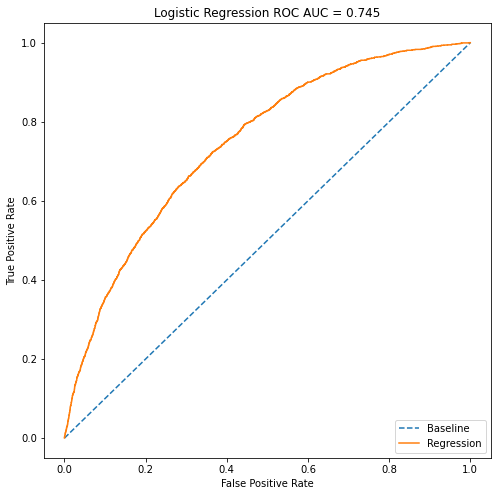

In [870]:
roc_auc_curve(y_test_3, y_pred_probs_6)

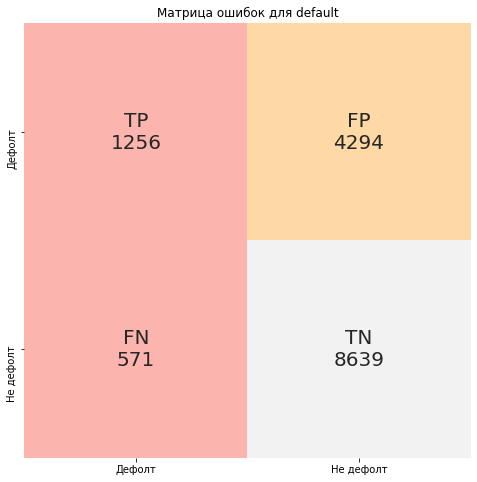

In [871]:
# и выведем confusion matrix
confusion_matrix_plot(y_test_3, y_pred_6)

Видим, что у последней модели все метрики стали намного лучше. Но для банка её всё ещё рано применять, нужно дальнейшее обогащение данными, которых нет. 

## ИТОГ: 

- проведен  анализ данных датасета
- устранены пропуски
- проведена нормализация данных
- создано 3 варианта датасетов из исходного для обучения моделей
- создано 6 моделей обучения в поисках лучшего варианта
- проведена балансировка классов в выборке
- проведен подбор гиперпарметров
- проведено обучние на новой модели LogisticRegressionCV
- проведена попытка обогатить данные - создать новые признаки за счёт уже имеющихся

## Рекомендация: 

необходимо получить дополнительные данные для уточнения работы модели:

- наличие поездок за рубеж за последние пол года (наличие загранпаспорта не показатель факта поездки за границу)
- если у банка есть данные о предприятии, то необходимо проводить и анализ информации о предприятиях, на которых работают клиенты, т.к. от их показателей тоже зависит платежеспособность клиента (его обеспеченность работой) 
- возможно стоить ориентироваться на наличие у организации счетов в зарубежных банках (с более низкими % по кредитам), но тогда учитывать и курс валютных пар инсотранная валюта / рубль.
- учитывать ставку рефинансирования ЦБ, т.к. от неё завсисит % выдаваемых кредитов в банках для организаций в том числе.

Т.к. у нас этих данных нет, то на submission отправляем последнюю модель, как самую удачную. 

## Финальная модель 

Считаем на полной выборке обучения, чтобы получить финальный результат:  

In [872]:
C_cv = np.logspace(-4, 4, 100)
lr_7 = LogisticRegressionCV(
    Cs=C_cv,
    cv=5,
    scoring='f1',
    solver='saga',
    tol=0.0001,
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42,
)

lr_7.fit(X_3, y_3)

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     class_weight='balanced', cv=5, max_iter=1000, n_jobs=-1,
                     random_state=42, scoring='f1', solver='saga')

In [873]:
probs_7 = lr_7.predict_proba(test_data_3)
y_pred_probs_7 = probs_7[:, 1]

y_pred_7 = lr_7.predict(test_data_3)

In [874]:
client_id = data_3[data_3['sample'] == 0]['client_id']

# Submission

In [875]:
my_submission = pd.DataFrame({
    'client_id': client_id,
    'default': y_pred_probs_7})

In [876]:
my_submission.to_csv('submission_us.csv', index=False)

In [877]:
my_submission.sample(5)

,client_id,default
9089,66002,0.154225
11643,5271,0.550437
31271,83756,0.370722
25079,11483,0.558229
24150,20283,0.686919


In [749]:
my_submission.shape

(36349, 2)

In [ ]:
submit